In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import random as random
import time

# Funciones

In [9]:
# Funcion que me hace el producto de kronecker de las matrices identidad y ponemos en la posicion pos una matriz dada
def kronecker(matriz, pos, n):
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
  #res = np.zeros((int(2**n), int(2**n)))
  if(pos == 0):
    res = matriz
  else:
    res = id

  for i in range(1, n):
    if(i == pos):
      res = np.kron(res, matriz)
    else:
      res = np.kron(res, id)
  return res

# Funcion que me crea el hamiltoninano del modelo de Dicke dado un cierto numero de spines y su operador salto
def dicke(N, params):
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)

  sigma = params[0]
  w = params[1]
  k = params[2]
  g = params[3]

  suma1 = kronecker(0.5*sz, 0, N)
  suma2 = kronecker(0.25*np.dot(sx, sx), 0, N)
  suma3 = kronecker(0.5*sx, 0, N)

  i = 1
  while(i < N):
    #print(i)
    suma1 += kronecker(0.5*sz, i, N)
    suma2 += kronecker(0.25*np.dot(sx, sx), i, N)
    suma3 += kronecker(0.5*sx, i, N)
    i += 1

  H = sigma*suma1 - ((4.0*w*g*g)/(4.0*w**2 + k**2))*(1.0/N)*suma2
  J = ((2.0*np.abs(g)*np.sqrt(k))/(np.sqrt(N*(4*w*w + k*k))))*suma3

  return H, J

# Funcion que me hace el ketbra de dos vectores
def ketbra(v1, v2):
  v2_conj = np.conjugate(v2)
  m = np.zeros((max(v1.shape[0], v1.shape[1]), max(v2.shape[0], v2.shape[1])), dtype = complex)
  for i in range(len(v1)):
    for k in range(len(v2)):
      m[i, k] = v1[i]*v2_conj[k]
  return m

# Funcion que me genera una matriz densidad inicial a partir de una combinacion lineal de los autoestados de Sz
def densidad(N):
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)

  # Construimos el operador sz
  suma = kronecker(0.5*sz, 0, N)
  i = 1
  while(i < N):
    suma += kronecker(0.5*sz, i, N)
    i += 1
  spin = suma
  #print(spin)

  # Creamos la base de autoestados de sz
  base = [np.linalg.eig(spin)[1][:, i] for i in range(spin.shape[0])]
  #print(base)

  # Construimos el vector inicial
  a, b = random.random(), random.random()
  ini = (a + b*1.j)*base[0]
  for i in range(1, len(base)):
    a, b = random.random(), random.random()
    ini += (a + b*1.j)*base[i]
  # Le hacemos el ketbra para construir la matriz densidad

  ini = ini/(np.linalg.norm(ini))
  d = ketbra(np.array(ini), np.array(ini))
  res = d/(np.linalg.norm(d))
  return res, ini

# Funcion que me crea una matriz cuadrada de simbolos

def matriz_cuadrada(n):
   matriz = sp.Matrix(n, n, lambda i,j: sp.Symbol('d_(%d)(%d)' % (i,j)))
   return matriz

# Iniciamos la semilla
import random
seed = 3457493
random.seed(a = seed, version = 2)

# Funcion que calcula el hamiltoniano efectivo
def H_eff(H, saltos):
  suma = np.zeros((H.shape[0], H.shape[1]), dtype = complex)
  for salto in saltos:
    suma += np.matrix(np.dot(salto.H, salto), dtype = complex)
  Heff = H - 0.5*(1.j)*suma
  return Heff

#Funcion para pasar de matriz a vector espacio de Fock-Liouville
def FL_vector(m):
  m_nuevo = np.reshape(m, m.shape[0]*m.shape[1])
  return sp.Matrix(m_nuevo, dtype = complex)

# Funcion para definir el Limbladiano como matriz en el espacio de Fock-Liouville
def Limblad(H, saltos):
  # Sacamos el hamiltoniano efectivo
  Heff = sp.Matrix(H_eff(H, saltos))

  # Creamos la matriz de simbolos
  d = matriz_cuadrada(H.shape[0])

  # Sacamos la suma de saltos
  suma = sp.zeros(H.shape[0], H.shape[1])
  for salto in saltos:
    suma += np.dot(np.dot(salto, d), salto.H)

  # Con esto, definimos el Limbladiano
  M = suma - sp.I*(np.dot(Heff, d) - np.dot(d, Heff.H))
  # Lo pasamos a vector
  M = FL_vector(M)

  # Lo pasamos de sistema de ecuaciones lineal a ecuacion matricial, b tiene que dar el vector de ceros
  #L, b = sp.linear_eq_to_matrix([elemento for elemento in M], [termino for termino in d])
  L, b = sp.linear_eq_to_matrix([M[i] for i in range(len(M))], [d[i] for i in range(len(d))])
  return L, b

# Funcion que calcula las nuevas probabilidades de salto y de no salto
def Calcularp(d, V):
  return np.trace(np.dot(np.dot(V, d), V.H))

# Funcion que nos calcula el nuevo estado tras un salto de tiempo
def NuevoEstado(d, V, H):
  return (np.dot(np.dot(V, d), (V.H)))/(np.sqrt(np.trace(np.dot(np.dot(V, d), (V.H)))))

# Funcion que nos hace un plot de lo que queramos
def ploteo_MC(d, tiempo):
  plt.ylabel(r'$\rho_{00}$')
  plt.xlabel('t')

  plt.plot(tiempo, d[0], 'bo', label = 'Random')
  plt.plot(tiempo, d[1], 'ro', label = 'Via del cero')
  plt.plot(tiempo, d[2], 'go', label = 'Via del no cero')
  #plt.plot(tiempo, d[3], 'yo', label = '2 ab(con)')
  #plt.plot(tiempo, d[4], 'b--', label = '1 cerr(sin)')
  #plt.plot(tiempo, d[5], 'r--', label = '1 cerr(con)')
  #plt.plot(tiempo, d[6], 'k--', label = '2 cerr(sin)')
  #plt.plot(tiempo, d[7], 'y--', label = '2 cerr(con)')

  plt.legend(loc = 'upper right')
  plt.show()

  return

# Funcion que nos saca la posicion del segundo valor mas grande en una lista
def segunda_posicion_mas_grande(lista):
    if len(lista) < 2:
        return "La lista no tiene suficientes elementos"

    # Encontrar el elemento más grande y su índice
    maximo = max(lista)
    indice_maximo = lista.index(maximo)

    # Eliminar el elemento más grande de la lista
    lista.remove(maximo)

    # Encontrar el segundo elemento más grande y su índice
    segundo_maximo = max(lista)
    indice_segundo_maximo = lista.index(segundo_maximo)

    # Ajustar el índice para tener en cuenta la eliminación del máximo anterior
    if indice_segundo_maximo >= indice_maximo:
        indice_segundo_maximo += 1

    return indice_segundo_maximo

# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
def Mpemba1(L, L_e, autovals, d, N, ini):

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(autovals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))

  todo = ((sp.Matrix(L1, dtype = complex)).H).eigenvects()
  vals = [tup[0] for tup in todo]
  vects = np.asarray([tup[2] for tup in todo], dtype = complex)
  #vals, vects = np.linalg.eig(L1)
  vals = list(np.array(vals, dtype = complex))
  print('Autovalores de L1: ')
  print(vals)

  # Normalizamos los autovectores de la matriz L1
  #vects = [matriz/np.linalg.norm(matriz) for matriz in vects]

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-14
  es_cero = [(np.abs(np.real(vals[i])) < tol) for i in range(len(vals))]
  #print(es_cero)

  if(any(es_cero)):
    print('Se puede hacer la vía del cero, con el autovalor: ')
    # Nos vamos al caso en el que un autovalor es 0
    indice = es_cero.index(True)
    print(vals[indice])
    print("Autovector con shape: " + str(vects[indice][0].shape) + ' es: ' + str(vects[indice][0]))
    U = ketbra(ini, vects[indice][0])
  else:
    print('No se ha podido hacer la via del cero')
    # Si no hay ningun autovalor que sea 0, se coje una pareja de autovalores con signo contrario
    U = np.zeros(d.shape)
  return U

# Funcion que nos saca el estado estacionario
def estacionario(L, d):
  # Diagonalizamos el lindbladiano
  LH = np.matrix(L.H, dtype = complex)
  L = np.matrix(L, dtype = complex)
  vals, vects_h = np.linalg.eig(LH)
  vals, vects = np.linalg.eig(L)
  vects = [matriz/np.linalg.norm(matriz) for matriz in vects]
  vects_h = [matriz/np.linalg.norm(matriz) for matriz in vects_h]

  # Sacamos el estado estacionario que es el autovector correspondiente al autovalor mas cercano a 0
  reales = [-np.real(valor) for valor in vals]
  minimo = max(reales)
  indice = reales.index(minimo)

  # Pasamos el estado estacionario a matriz
  r = np.reshape(vects[indice], (d.shape[0], d.shape[1]))
  l = np.reshape(vects_h[indice], (d.shape[0], d.shape[1]))

  res = np.trace(np.dot(l, d))*r

  return r/np.trace(r)

# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
def Mpemba2(L, d, N, ini):
  # Diagonalizamos el lindbladiano
  # Sacamos los autovalores y los autovectores del Limbladiano
  L_H = np.matrix(L.H, dtype = complex)
  vals, L_e = np.linalg.eig(L_H)

  # Normalizamos las automatrices
  L_e = [np.reshape(matriz, (d.shape[0], d.shape[1])) for matriz in L_e]
  L_e = [matriz.T/(np.linalg.norm(matriz)) for matriz in L_e]

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(vals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))

  vals, vects = np.linalg.eig(L1)
  vals = list(vals)
  print('Autovalores de L1: ')
  print(vals)
  #print(vects)
  # Normalizamos los autovectores de la matriz L1
  vects = [matriz/np.linalg.norm(matriz) for matriz in vects]

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-14 # N = 5
  #tol = 1.0e-3
  es_cero = [(np.abs(np.real(vals[i])) < tol) for i in range(len(vals))]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  indice_contrario = 0
  indice_inicial = es_cero.index(False)
  es_contrario = [np.real(vals[indice_inicial])*np.real(vals[i]) < 0 for i in range(len(vals))]
  if(any(es_contrario)):
    indice_contrario = es_contrario.index(True)
    F = ketbra(vects[indice_inicial].T, vects[indice_contrario].T) + ketbra(vects[indice_contrario].T, vects[indice_inicial].T)
    s = np.arctan(np.sqrt((np.abs(vals[indice_inicial]))/(np.abs(vals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    print((vals[indice_inicial], vals[indice_contrario]))
    identidad = kronecker(id, 0, N)
    U = identidad + (np.cos(s) - 1.0)*(np.dot(F, F)) - 1.j*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)

  return U

def indices_mayores_que_100(matriz, n):
    indices = []
    filas = matriz.shape[0]
    columnas = matriz.shape[1]

    for i in range(filas):
        for j in range(columnas):
            if(np.real(matriz[i, j]) > n):
                indices.append((i, j))

    return indices

def indices_mayores_que_100(matriz, n):
    indices = []
    filas = matriz.shape[0]
    columnas = matriz.shape[1]

    for i in range(filas):
        for j in range(columnas):
            if(np.real(matriz[i, j]) > n):
                indices.append((i, j))

    return indices

In [10]:
# Funcion que nos saca el estado estacionario
def estacionario(L, d):
  # Diagonalizamos el lindbladiano
  #LH = np.matrix(L.H, dtype = complex)
  #L = np.matrix(L, dtype = complex)
  #vals, vects_h = np.linalg.eig(LH)
  #vals, vects = np.linalg.eig(L)
  #vects = [matriz/np.linalg.norm(matriz) for matriz in vects]
  #vects_h = [matriz/np.linalg.norm(matriz) for matriz in vects_h]

  # Sacamos los autovalores y los autovectores del Limbladiano
  todo = L.eigenvects()
  #vals = list(sp.simplify(L.eigenvals()).keys())
  vals = [tup[0] for tup in todo]
  vects = [np.array(tup[2], dtype = complex) for tup in todo]
  #L_e = [sp.Matrix(tup[2][0]) for tup in (L.H).eigenvects()]

  # Normalizamos las automatrices
  #R_e = [matriz/matriz.norm() for matriz in R_e]
  #L_e = [matriz/matriz.norm() for matriz in L_e]

  # Sacamos el estado estacionario que es el autovector correspondiente al autovalor mas cercano a 0
  #reales = [-np.abs(valor) for valor in vals]
  vals = np.array(vals, dtype = complex)
  espositivo = False
  for elemento in vals:
    if(elemento > 0.0):
      indice = list(vals).index(elemento)
      espositivo = True
  if(espositivo == False):
    reales = [np.real(valor) for valor in np.array(vals, dtype = complex)]
    minimo = max(reales)
    indice = reales.index(minimo)

  # Pasamos el estado estacionario a matriz
  r = np.reshape(vects[indice], (d.shape[0], d.shape[1]))
  #l = np.reshape(vects_h[indice], (d.shape[0], d.shape[1]))

  #res = np.trace(np.dot(l, d))*r

  #return r/np.trace(r)
  #return res/np.trace(res)
  if(np.imag(np.trace(r)) < 1e-10):
    res = r/np.trace(np.real(r))
  else:
    res = r/np.trace(r)
  return res

  # Funcion que nos resuelve la ecuacion maestra igualada a 0
def ec_maestra(L, H):
  d = FL_vector(matriz_cuadrada(H.shape[0]))
  sol = sp.solve(L*d, [d[i] for i in range(len(d))])
  return sol

# Funcion que resuelve el sistema mediante el metodo de montecarlo
def ResolverSistema(d0, H, salto, N, nveces):
  # Establecemos un limite de tiempo
  t = 0.0
  limite = 100.0
  tiempo = [t]
  dt = 0.01

  vector_fotones = []
  nfotones = 0 # numero de fotones
  res = [d0]
  # Hamiltoniano efectivo
  Heff = H_eff(H, salto)

  # Operadores de evolución y de salto del sistema
  V = [np.sqrt(dt)*J for J in salto]
  V_0 = kronecker(id, 0, N) - 1.j*dt*Heff

  intentos = [] #Aqui guardamos todos los resultados para cada realizacion

  # Calculamos las probabilides iniciales
  p0 = Calcularp(d0, V_0)
  p = Calcularp(d0, V[0])
  d = d0
  # Empezamos con el bucle
  while(t < limite):
    prob = random.random()
    if(prob < p):
      nfotones += 1
      d = NuevoEstado(d, V[0], H)
    else:
      d = NuevoEstado(d, V_0, H)
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    res.append(d)
    t += dt
    tiempo.append(t)

  vector_fotones.append(nfotones)
  intentos.append(res)
  # Ahora, hacemos el bucle otras nveces-1 veces para luego promediar
  indice = 1
  while(indice < nveces):
    d = d0
    nfotones = 0
    res = [d0]
    t = 0.0
    # Calculamos las probabilidades iniciales
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    while(t < limite):
      prob = random.random()
      if(prob < p):
        nfotones += 1
        d = NuevoEstado(d, V[0], H)
      else:
        d = NuevoEstado(d, V_0, H)
      p0 = Calcularp(d, V_0)
      p = Calcularp(d, V[0])
      res.append(d)
      t += dt
    intentos.append(res)
    indice += 1
    vector_fotones.append(nfotones)

  # Por último calculamos el promedio de las trayectorias
  suma = [0 for i in range(len(intentos[0]))]
  for i in range(len(intentos[0])):
    for elemento in intentos:
      suma[i] += elemento[i]
  final = [elemento/nveces for elemento in suma]
  return final, tiempo, vector_fotones

# Funcion que nos dice si la matriz l2 es hermitica segun los parametros que le pasemos
def L2hermitica(N, params, d):
  # Sacamos el hamiltoniano y los operadores de salto
  H, J = dicke(N, params)
  # Sacamos el lindbladiano
  L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])

  # Diagonalizamos el lindbladiano
  #L_H = np.matrix(L.H, dtype = complex)
  #vals, L_e = np.linalg.eig(L_H)
  todo = (L.H).eigenvects()
  vals = np.array([tup[0] for tup in todo], dtype = complex)
  L_e = [tup[2] for tup in todo]
  # Normalizamos las automatrices
  L_e = [np.reshape(matriz, (d.shape[0], d.shape[1])) for matriz in L_e]
  #L_e = [matriz.T/(np.linalg.norm(matriz)) for matriz in L_e]

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(vals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))

  # Una vez obtenida L2, vemos si es hermitica
  import scipy as sc
  return sc.linalg.ishermitian(L1), vals[indice_segundo_maximo]

def eliminar_duplicados(lista):
    # Convierte la lista a un conjunto para eliminar duplicados
    conjunto_sin_duplicados = set(lista)

    # Convierte el conjunto de nuevo a una lista
    lista_sin_duplicados = list(conjunto_sin_duplicados)

    return lista_sin_duplicados

# Ejemplo de uso
mi_lista = [1, 2, 3, 2, 4, 5, 1, 6, 7, 8, 6, 9]
lista_sin_duplicados = eliminar_duplicados(mi_lista)

print("Lista original:", mi_lista)
print("Lista sin duplicados:", lista_sin_duplicados)

# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
# Esta es otra version que nos dara la transformacion pero a partir de los autovalores de lindbladiano
def Mpemba2(L, L_e, vals, d, N, ini):
  # Diagonalizamos el lindbladiano
  # Sacamos los autovalores y los autovectores del Limbladiano
  #L_H = np.matrix(L.H, dtype = complex)
  #vals, L_e = np.linalg.eig(L_H)

  # Normalizamos las automatrices
  #L_e = sp.Matrix([np.reshape(matriz, (d.shape[0], d.shape[1])) for matriz in L_e], dtype = complex)
  #L_e = [matriz.T/(np.linalg.norm(matriz)) for matriz in L_e]

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(np.array(vals, dtype = complex)))
  maximo = max(lista_vals)
  print('Maximo: ' + str(maximo))
  indice_maximo = lista_vals.index(max(lista_vals))
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = sp.Matrix(np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1])), dtype = complex)

  todo = L1.eigenvects()
  #vals = list(sp.simplify(L.eigenvals()).keys())
  autovals = [tup[0] for tup in todo]
  autovects = [np.array(tup[2][0], dtype = complex) for tup in todo]
  #vals, vects = np.linalg.eig(L1)
  autovals = list(np.array(autovals, dtype = complex))
  print('Autovalores de L1: ')
  print(autovals)
  #print(vects)
  # Normalizamos los autovectores de la matriz L1
  #vects = [matriz/np.linalg.norm(matriz) for matriz in vects]

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-14 # N = 5
  #tol = 1.0e-3
  autovals = eliminar_duplicados(autovals)
  es_cero = [(np.abs(np.real(autovals[i])) < tol) for i in range(len(autovals))]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  indice_contrario = 0
  indice_inicial = es_cero.index(False)
  autovals = eliminar_duplicados(autovals)
  es_contrario = [np.real(autovals[indice_inicial])*np.real(autovals[i]) < 0 for i in range(len(autovals))]
  if(any(es_contrario)):
    indice_contrario = es_contrario.index(True)
    print('(indice contrario, indice inicial, len(autovects)) = ' + str(indice_contrario) + ', ' + str(indice_inicial) + ', '  + ' ' + str(autovects[0].shape))
    F = ketbra(autovects[indice_inicial], autovects[indice_contrario]) + ketbra(autovects[indice_contrario], autovects[indice_inicial])
    s = np.arctan(np.sqrt((np.abs(autovals[indice_inicial]))/(np.abs(autovals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    print((autovals[indice_inicial], autovals[indice_contrario]))
    identidad = kronecker(id, 0, N)
    U = identidad + (np.cos(s) - 1.0)*(np.dot(F, F)) - 1.j*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)

  return U

def indices_mayores_que_100(matriz, n):
    indices = []
    filas = matriz.shape[0]
    columnas = matriz.shape[1]

    for i in range(filas):
        for j in range(columnas):
            if(np.real(matriz[i, j]) > n):
                indices.append((i, j))

    return indices

# Funcion que te calcula el estado estacionario del lindbladiano, le pasamos los autovalores y autovecores
def estacionario(vals, vects, d):
  vals = np.array(vals, dtype = complex)
  espositivo = False
  indices_positivos = []
  for elemento in vals:
    if(elemento > 0.0):
      indices_positivos.append(list(vals).index(elemento))
      #indice = list(vals).index(elemento)
      espositivo = True
  if(espositivo == True):
    valores_positivos = [vals[i] for i in indices_positivos]
    indice = list(-np.real(vals)).index(max(list(-np.real(valores_positivos))))
  if(espositivo == False):
    reales = [np.real(valor) for valor in np.array(vals, dtype = complex)]
    minimo = max(reales)
    indice = reales.index(minimo)

  # Pasamos el estado estacionario a matriz
  r = np.reshape(vects[indice], (d.shape[0], d.shape[1]))
  #l = np.reshape(vects_h[indice], (d.shape[0], d.shape[1]))

  #res = np.trace(np.dot(l, d))*r

  #return r/np.trace(r)
  #return res/np.trace(res)
  if(np.imag(np.trace(r)) < 1e-10):
    res = r/np.trace(np.real(r))
  else:
    res = r/np.trace(r)
  return res

Lista original: [1, 2, 3, 2, 4, 5, 1, 6, 7, 8, 6, 9]
Lista sin duplicados: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [4]:
r = estacionario(L, d0)

NameError: name 'L' is not defined

In [ ]:
todo = L.eigenvects()

In [ ]:
[tup[0] for tup in todo]

In [ ]:
np.trace(r)

(-0.27196908446533496-0.8224266591677756j)

In [ ]:
res = r/np.trace((r))
np.trace(res)

(0.9999999999999998-5.551115123125783e-17j)

In [ ]:
res

In [ ]:
[np.linalg.norm(np.array(tup[2], dtype = complex)) for tup in todo]

[1.0, 1.0018048746260761, 1.0, 1.0]

In [ ]:
lista = []
for vector in vects:
  lista.append(indices_mayores_que_100(vector, 1.0))
for elemento in lista:
  if(elemento != []):
    print(elemento)

In [ ]:
indices_mayores_que_100(np.matrix(estacionario(L, densidad(N)), dtype = complex), 100)

[]

Ponemos en marcha la obtención de la transformación unitaria basada en el efecto MPemba.

In [4]:
# Funcion que me crea el hamiltoninano del modelo de Dicke dado un cierto numero de spines y su operador salto
# pero con los parametros del articulo de CArollo (no funciona porque los operadores no tienen el mismo tamaño)
def dicke_Carollo(N):
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)

  sigma = params[0]
  w = params[1]
  k = params[2]
  g = params[3]

  suma1 = kronecker(0.5*sz, 0, N)
  suma2 = kronecker(0.25*np.dot(sx, sx), 0, N)
  suma3 = kronecker(0.5*sx, 0, N)

  i = 1
  while(i < N):
    #print(i)
    suma1 += kronecker(0.5*sz, i, N)
    suma2 += kronecker(0.25*np.dot(sx, sx), i, N)
    suma3 += kronecker(0.5*sx, i, N)
    i += 1

  H = suma1 - (1.0/50.0)*suma2
  J = np.sqrt(1.0/50.0)*suma3

  return H, J

# Poner en marcha el modelo

In [ ]:
dt = 0.01 #salto de tiempo

# Medimos el tiempo
t1 = time.time()

# Matrices de Pauli
id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
num = np.matrix([[1.0, 0.0], [0.0, 0.0]], dtype = complex)

# Hamiltoniano, operador salto y hamiltoniano efecivo
N = 1
sigma = 1.0
nveces = 8e2
w = 1.0*sigma
k = 1.0*sigma
g = 1.0*sigma
params = [sigma, w, k, g]
H, J = dicke(N, params)

# Matriz densidad
d0, ini = densidad(N)

L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])
todo = L.eigenvects()
#vals = list(sp.simplify(L.eigenvals()).keys())
autovals = [tup[0] for tup in todo]
autovects = [np.array(tup[2], dtype = complex) for tup in todo]
U2 = Mpemba2(L, autovects, np.array(autovals, dtype = complex), d0, N, ini) # Via no trivial (no cero)
U1 = Mpemba1(L, autovects, np.array(autovals, dtype = complex), d0, N, ini) # Via trivial (cero)
duracion = time.time() - t1

def guardar_matriz_en_archivo(matriz, nombre_archivo):
    try:
        with open(nombre_archivo, 'w') as archivo:
            for fila in matriz:
                fila_str = ' '.join(map(str, fila))
                archivo.write(fila_str + '\n')
        print(f"Matriz guardada exitosamente en {nombre_archivo}")
    except Exception as e:
        print(f"Error al guardar la matriz en el archivo: {e}")

nombre_archivo_salida = 'Mpemba.dat'
guardar_matriz_en_archivo(U1, nombre_archivo_salida)

d0_exp1 = np.dot(np.dot(U1, d0), np.conjugate(U1.T))
d0_exp2 = np.dot(np.dot(U2, d0), np.conjugate(U2.T))
print(d0.shape)
v1, tiempo, n1 = ResolverSistema(d0, H, [J], N, nveces)
v2, tiempo, n2 = ResolverSistema(d0_exp1, H, [J], N, nveces)
v3, tiempo, n3 = ResolverSistema(d0_exp2, H, [J], N, nveces)

dens = [v1, v2, v3]
#dens = [v1, v2]

Maximo: 0.39999999999999997
Autovalores de L1: 
[(0.22360679774997896-0.22360679774997896j), (-0.22360679774997896+0.22360679774997896j)]
Vamos a probar la via del no cero
(indice contrario, indice inicial, len(autovects)) = 1, 0,  (2, 1)
La s me sale: 0.7853981633974483 se ha cogido la s que sale de los autovalores: 
((0.22360679774997896-0.22360679774997896j), (-0.22360679774997896+0.22360679774997896j))
Autovalores de L1: 
[(-0.22360679774997896-0.22360679774997896j), (0.22360679774997896+0.22360679774997896j)]
No se ha podido hacer la via del cero
Matriz guardada exitosamente en Mpemba.dat
(2, 2)


/tmp/ipykernel_42334/2496503862.py:142: RuntimeWarning: invalid value encountered in divide
  return (np.dot(np.dot(V, d), (V.H)))/(np.sqrt(np.trace(np.dot(np.dot(V, d), (V.H)))))


In [ ]:
sp.Matrix(U2, dtype = complex)

Matrix([
[   0.842035024206609 + 0.64934645849316*I,   0.113890071590882 - 0.0769227440002975*I,      0.147933508743669 - 0.271835641652312*I,   0.0162265321589611 - 0.0845574801669906*I],
[ -0.078950031127669 - 0.106265390301265*I,   0.994241198746063 - 0.0307292695686582*I,  -0.0394101189418029 + 0.00575985143801892*I, -0.0153231063540427 + 0.00659297904051515*I],
[-0.0335905011727945 - 0.309344094391328*I, 0.0186501428524348 - 0.00575985143801892*I,      0.97232065063673 + 0.0307292695686582*I, -0.0115553266919216 + 0.00661962157055727*I],
[0.0162265321589611 - 0.0864258780150337*I,  0.010883157351422 + 0.00159221011478433*I, -0.00329509967867559 + 0.00207582713733051*I,   0.997793057718116 - 0.00132027914499376*I]])

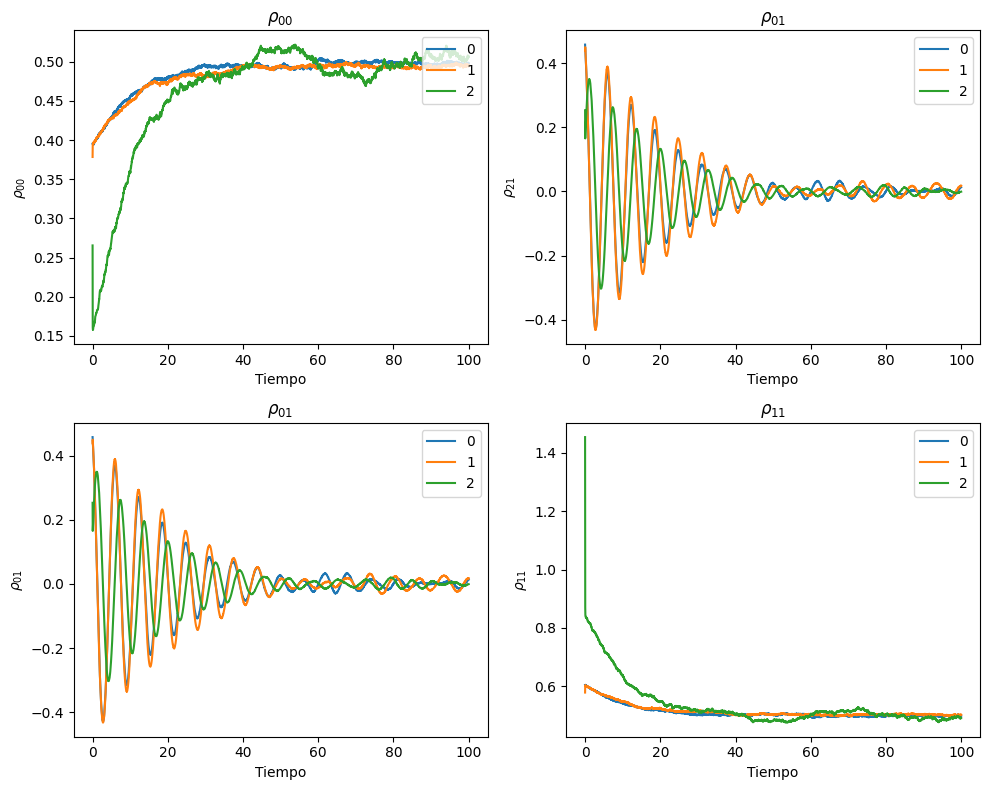

In [ ]:
#tiempo = np.linspace(0, 100, int(100/dt) + 1)

# Configura subfiguras con ejes individuales
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

#d = len(vector_x)
d = 3
# Subfigura 1
vector_x = [[np.real(v[i][v[i].shape[0]-2, v[i].shape[1]-2]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[0, 0].plot(tiempo, vector_x[i], label = str(i))
axs[0, 0].set_title(r'$\rho_{00}$')
axs[0, 0].set_xlabel('Tiempo')
axs[0, 0].set_ylabel(r'$\rho_{00}$')
axs[0, 0].legend(loc = 'upper right')

# Subfigura 2
vector_y = [[np.real(v[i][0, 1]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[0, 1].plot(tiempo, vector_y[i], label = str(i))
#axs[0, 1].plot(tiempo, vector2)
axs[0, 1].set_title(r'$\rho_{01}$')
axs[0, 1].set_xlabel('Tiempo')
axs[0, 1].set_ylabel(r'$\rho_{21}$')
axs[0, 1].legend(loc = 'upper right')

# Subfigura 3
vector_z = [[np.real(v[i][0, 1]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[1, 0].plot(tiempo, vector_z[i], label = str(i))
#axs[1, 0].plot(tiempo, vector3)
axs[1, 0].set_title(r'$\rho_{01}$')
axs[1, 0].set_xlabel('Tiempo')
axs[1, 0].set_ylabel(r'$\rho_{01}$')
axs[1, 0].legend(loc = 'upper right')

# Subfigura 4
vector_num = [[np.real(v[i][1, 1]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[1, 1].plot(tiempo, vector_num[i], label = str(i))
#axs[1, 1].plot(tiempo, vector4)
axs[1, 1].set_title(r'$\rho_{11}$')
axs[1, 1].set_xlabel('Tiempo')
axs[1, 1].set_ylabel(r'$\rho_{11}$')
axs[1, 1].legend(loc = 'upper right')


# Ajusta el diseño para evitar superposición de etiquetas
plt.tight_layout()

# Muestra las subfiguras
plt.show()

[1, 5, 8, 4, 3, 5, 5, 2, 6, 5, 5, 5, 3, 4, 2, 1, 5, 6, 4, 8, 4, 9, 3, 4, 5, 5, 0, 4, 2, 4, 6, 6, 5, 7, 5, 8, 6, 7, 5, 3, 5, 4, 3, 6, 3, 1, 3, 5, 7, 4, 8, 3, 4, 1, 1, 5, 7, 4, 5, 4, 3, 6, 6, 11, 4, 4, 4, 4, 6, 7, 3, 4, 8, 4, 2, 2, 6, 4, 8, 3, 3, 5, 6, 8, 5, 11, 4, 0, 2, 9, 7, 5, 8, 6, 4, 4, 4, 4, 5, 5, 9, 4, 7, 6, 5, 4, 7, 3, 5, 5, 8, 2, 4, 4, 5, 5, 4, 3, 5, 7, 3, 11, 9, 5, 5, 1, 4, 7, 3, 5, 0, 4, 4, 3, 5, 3, 8, 3, 8, 7, 5, 5, 6, 6, 4, 4, 4, 6, 6, 11, 3, 3, 4, 5, 3, 6, 4, 7, 5, 5, 3, 14, 7, 3, 4, 8, 9, 8, 6, 4, 5, 3, 9, 2, 3, 9, 3, 4, 8, 3, 4, 2, 5, 2, 2, 3, 4, 4, 1, 4, 4, 6, 1, 9, 6, 4, 7, 2, 6, 2, 5, 3, 9, 6, 5, 2, 6, 5, 2, 6, 3, 5, 6, 5, 5, 7, 3, 4, 4, 5, 6, 3, 5, 1, 4, 5, 7, 2, 4, 6, 6, 3, 4, 3, 7, 6, 2, 5, 5, 1, 1, 4, 5, 5, 6, 1, 5, 4, 7, 5, 5, 7, 4, 2, 11, 7, 6, 6, 7, 3, 3, 5, 5, 12, 4, 8, 2, 7, 3, 5, 3, 0, 3, 6, 4, 5, 6, 4, 4, 6, 4, 3, 3, 3, 4, 5, 4, 2, 9, 3, 6, 7, 4, 6, 7, 4, 3, 1, 5, 4, 4, 6, 3, 2, 5, 5, 2, 5, 3, 2, 2, 7, 5, 4, 2, 7, 1, 1, 7, 3, 4, 4, 6, 10, 3, 3, 5, 5, 5, 6, 2

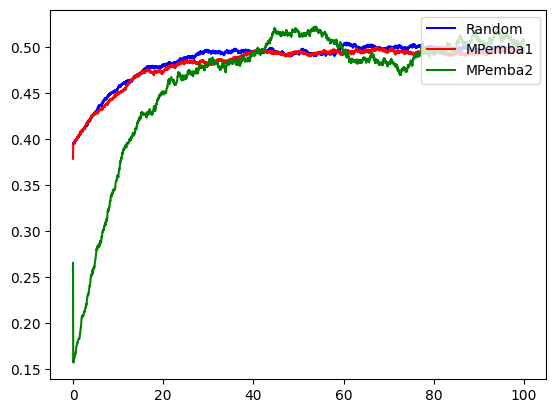

He tardado 0.057956695556640625 segundos.


In [ ]:
ob = [[np.real(v[i][v[i].shape[0]-2, v[i].shape[1]-2]) for i in range(len(v))] for v in dens]
#ob = [[np.real(v[i][5, 5]) for i in range(len(v))] for v in dens]
print(n1)
print(n2)
print(n3)
plt.plot(tiempo, ob[0], 'b-', label = 'Random')
plt.plot(tiempo, ob[1], 'r-', label = 'MPemba1')
plt.plot(tiempo, ob[2], 'g-', label = 'MPemba2')
plt.legend(loc = 'upper right')
plt.show()
print(f"He tardado {duracion} segundos.")

In [ ]:
r = estacionario(autovals, autovects, d0)

In [ ]:
r

array([[ 0.5+7.64071328e-39j, -0. -0.00000000e+00j],
       [-0. -0.00000000e+00j,  0.5+5.30299909e-71j]])

In [ ]:
np.trace(r), np.trace(np.dot(r, r)), np.linalg.norm(r)

((1+7.640713280344869e-39j), (0.5+7.640713280344869e-39j), 0.7071067811865476)

In [ ]:
len(v1)
#tiempo = np.linspace(0.0, 100.0, int(100/dt) + 1)

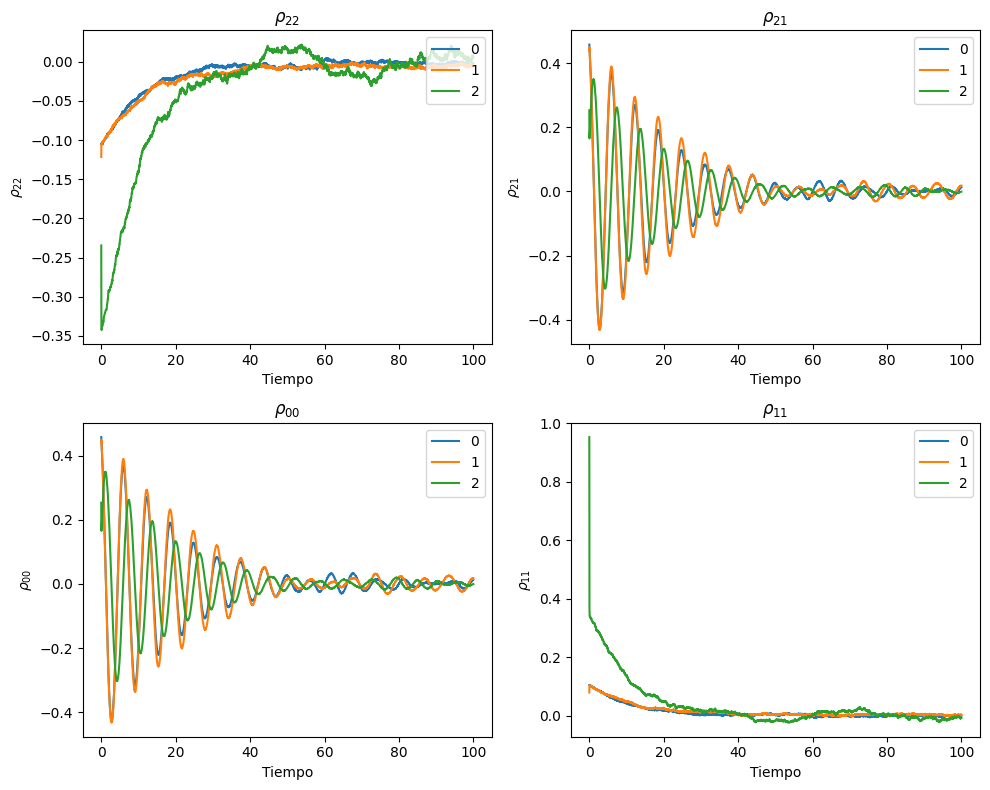

In [ ]:
#tiempo = np.linspace(0, 100, int(100/dt) + 1)

# Configura subfiguras con ejes individuales
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

#d = len(vector_x)
d = 3
# Subfigura 1
vector_x = [[np.real((v[i]-r)[v[i].shape[0]-2, v[i].shape[1]-2]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[0, 0].plot(tiempo, vector_x[i], label = str(i))
axs[0, 0].set_title(r'$\rho_{22}$')
axs[0, 0].set_xlabel('Tiempo')
axs[0, 0].set_ylabel(r'$\rho_{22}$')
axs[0, 0].legend(loc = 'upper right')

# Subfigura 2
vector_y = [[np.real((v[i]-r)[0, 1]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[0, 1].plot(tiempo, vector_y[i], label = str(i))
#axs[0, 1].plot(tiempo, vector2)
axs[0, 1].set_title(r'$\rho_{21}$')
axs[0, 1].set_xlabel('Tiempo')
axs[0, 1].set_ylabel(r'$\rho_{21}$')
axs[0, 1].legend(loc = 'upper right')

# Subfigura 3
vector_z = [[np.real((v[i]-r)[1, 0]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[1, 0].plot(tiempo, vector_z[i], label = str(i))
#axs[1, 0].plot(tiempo, vector3)
axs[1, 0].set_title(r'$\rho_{00}$')
axs[1, 0].set_xlabel('Tiempo')
axs[1, 0].set_ylabel(r'$\rho_{00}$')
axs[1, 0].legend(loc = 'upper right')

# Subfigura 4
vector_num = [[np.real((v[i]-r)[1, 1]) for i in range(len(v))] for v in dens]
for i in range(d):
  axs[1, 1].plot(tiempo, vector_num[i], label = str(i))
#axs[1, 1].plot(tiempo, vector4)
axs[1, 1].set_title(r'$\rho_{11}$')
axs[1, 1].set_xlabel('Tiempo')
axs[1, 1].set_ylabel(r'$\rho_{11}$')
axs[1, 1].legend(loc = 'upper right')


# Ajusta el diseño para evitar superposición de etiquetas
plt.tight_layout()

# Muestra las subfiguras
plt.show()

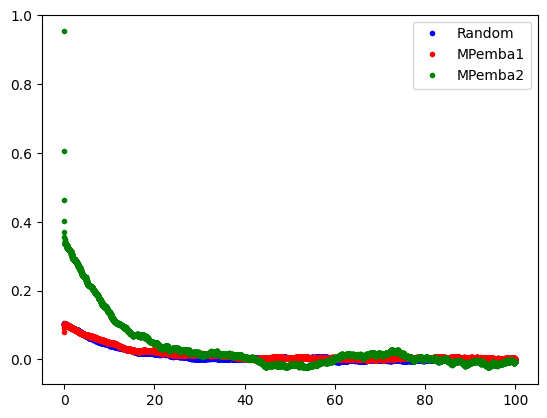

In [ ]:
# Sacamos la distancia de Hilbert Schmidt para todo tiempo t
ob = [[np.real((v[i] - r)[1, 1]) for i in range(len(v))] for v in dens]
plt.plot(tiempo, ob[0], 'b.', label = 'Random')
plt.plot(tiempo, ob[1], 'r.', label = 'MPemba1')
plt.plot(tiempo, ob[2], 'g.', label = 'MPemba2')
#plt.xlim(2, 200)
#plt.ylim(0.8, 1.2)
#plt.ylim(0.99, 1.01)
plt.legend(loc = 'upper right')
plt.show()
#ploteo_MC(ob, tiempo)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


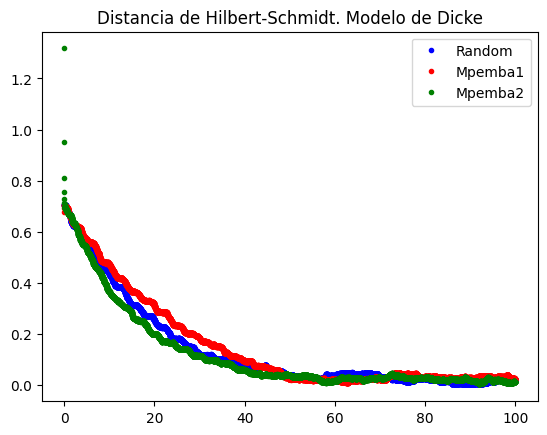

In [ ]:
# Sacamos la distancia de Hilbert Schmidt para todo tiempo t
#ob = [[np.sqrt(np.trace((v[i] - r))) for i in range(len(v))] for v in dens]
#ob = [[np.sqrt(np.trace(np.dot((v[i] - r), (v[i] - r)))) for i in range(len(v))] for v in dens]
ob1 = [np.sqrt(np.trace(np.dot(matriz-r, matriz-r))) for matriz in dens[0]]
ob2 = [np.sqrt(np.trace(np.dot(matriz-r, matriz-r))) for matriz in dens[1]]
ob = [[np.sqrt(np.trace(np.dot(v[i]-r, v[i]-r))) for i in range(len(v))] for v in dens]
plt.plot(tiempo, ob1, 'b.', label = 'Random')
plt.plot(tiempo, ob2, 'r.', label = 'Mpemba1')
plt.plot(tiempo, ob[2], 'g.', label = 'Mpemba2')
#plt.xlim(2, 200)
#plt.ylim(0.8, 1.2)
#plt.ylim(0.998, 1.0040)
plt.legend(loc = 'upper right')
plt.title('Distancia de Hilbert-Schmidt. Modelo de Dicke')
plt.show()
#ploteo_MC(ob, tiempo)

<ipython-input-16-6e4f76bd6d33>:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(tiempo), np.log(ob1), 'b-', label = 'Random')
<ipython-input-16-6e4f76bd6d33>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(tiempo), np.log(ob2), 'r-', label = 'Mpemba1')
<ipython-input-16-6e4f76bd6d33>:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(tiempo), np.log(ob[2]), 'g-', label = 'Mpemba2')


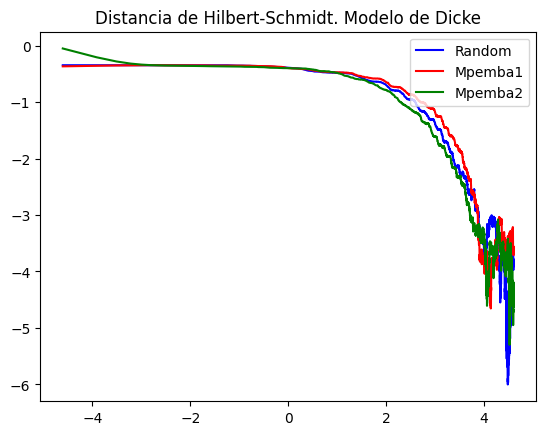

In [ ]:
# Sacamos la distancia de Hilbert Schmidt para todo tiempo t
#ob = [[np.sqrt(np.trace((v[i] - r))) for i in range(len(v))] for v in dens]
#ob = [[np.sqrt(np.trace(np.dot((v[i] - r), (v[i] - r)))) for i in range(len(v))] for v in dens]
ob1 = [np.sqrt(np.trace(np.dot(matriz-r, matriz-r))) for matriz in dens[0]]
ob2 = [np.sqrt(np.trace(np.dot(matriz-r, matriz-r))) for matriz in dens[1]]
ob = [[np.sqrt(np.trace(np.dot(v[i]-r, v[i]-r))) for i in range(len(v))] for v in dens]
plt.plot(np.log(tiempo), np.log(ob1), 'b-', label = 'Random')
plt.plot(np.log(tiempo), np.log(ob2), 'r-', label = 'Mpemba1')
plt.plot(np.log(tiempo), np.log(ob[2]), 'g-', label = 'Mpemba2')
#plt.xlim(2, 200)
#plt.ylim(0.8, 1.2)
#plt.ylim(0.998, 1.0040)
plt.legend(loc = 'upper right')
plt.title('Distancia de Hilbert-Schmidt. Modelo de Dicke')
plt.show()
#ploteo_MC(ob, tiempo)

In [ ]:
n1, n2, n3

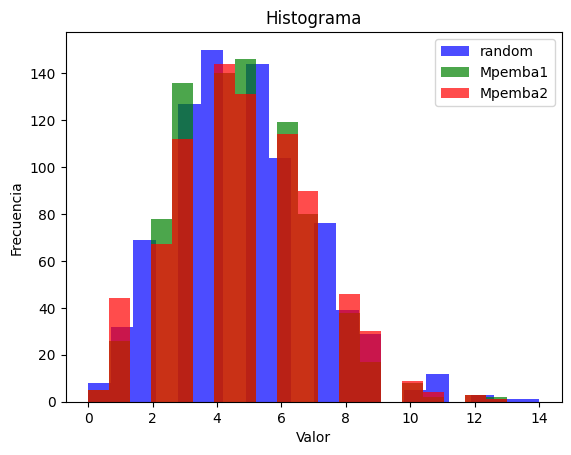

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Genera un vector de datos aleatorios (puedes reemplazarlo con tus datos)

# Crea un histograma
plt.hist(n1, bins=20, color='blue', alpha=0.7, label = 'random')
plt.hist(n2, bins = 20, color = 'green', alpha = 0.7, label = 'Mpemba1')
plt.hist(n3, bins = 20, color = 'red', alpha = 0.7, label = 'Mpemba2')
plt.legend(loc = 'upper right')


# Añade etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma')

# Muestra el histograma
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


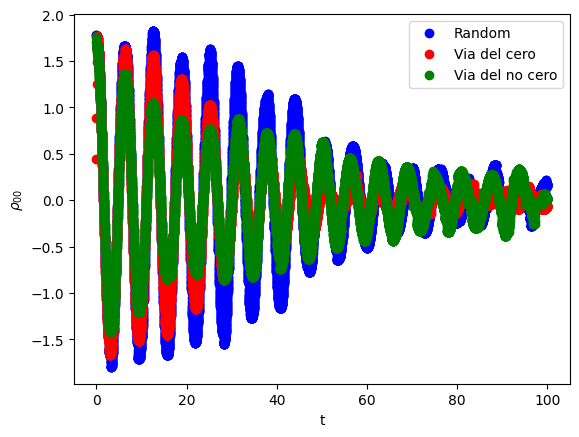

In [ ]:
#s = (sx*sx + sy*sy + sz*sz)
#s = id
s = 0.5*sx
suma = kronecker(s, 0, N)
i = 1
while(i < N):
  suma += kronecker(s, i, N)
  i += 1
spin = suma
ob = [[np.trace(spin*(v[i])) for i in range(len(v))] for v in dens]

ploteo_MC(ob, tiempo)

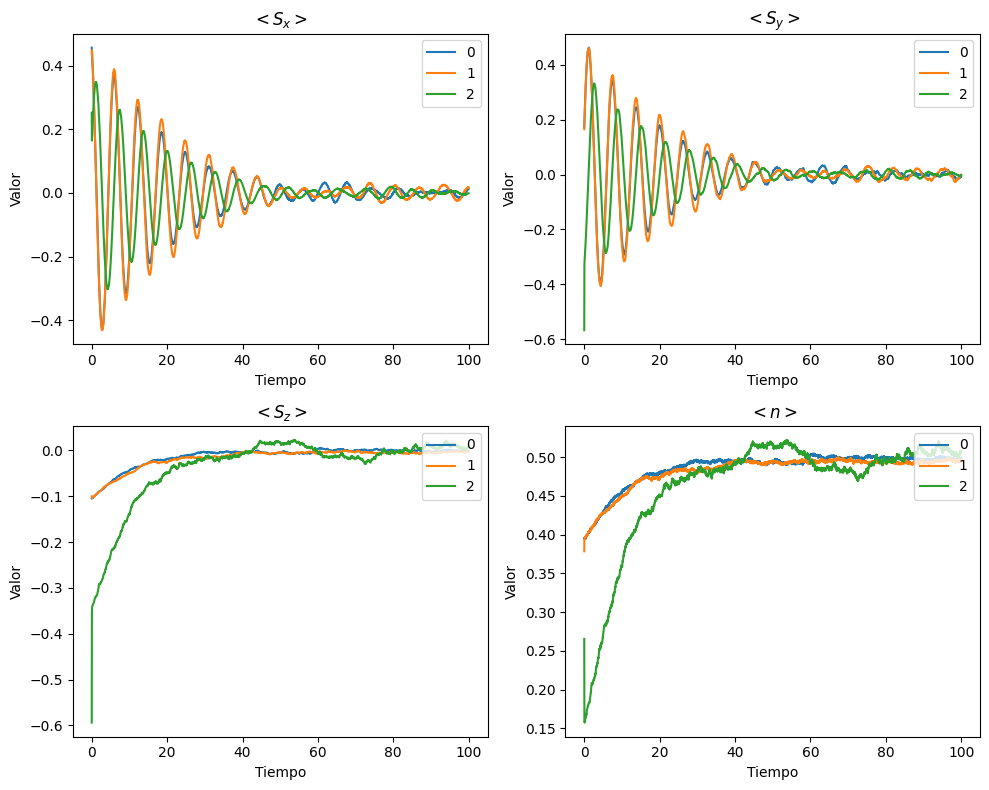

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Genera datos de ejemplo (puedes reemplazarlos con tus datos)
#tiempo = np.linspace(0, 100, int(100/dt) + 1)
vector1 = np.sin(tiempo)
vector2 = np.cos(tiempo)
vector3 = np.sin(2 * tiempo)
vector4 = np.cos(2 * tiempo)

# Generamos los valores esperados
# Operador sx
s = 0.5*sx
suma_x = kronecker(s, 0, N)
i = 1
while(i < N):
  suma_x += kronecker(s, i, N)
  i += 1
vector_x = [[np.trace(suma_x*(v[i])) for i in range(len(v))] for v in dens]

# Operador sy
s = 0.5*sy
suma_y = kronecker(s, 0, N)
i = 1
while(i < N):
  suma_y += kronecker(s, i, N)
  i += 1
vector_y = [[np.trace(suma_y*(v[i])) for i in range(len(v))] for v in dens]

# Operador sz
s = 0.5*sz
suma_z = kronecker(s, 0, N)
i = 1
while(i < N):
  suma_z += kronecker(s, i, N)
  i += 1
vector_z = [[np.trace(suma_z*(v[i])) for i in range(len(v))] for v in dens]

# Operador numero
s = num
suma_num = kronecker(s, 0, N)
i = 1
while(i < N):
  suma_num += kronecker(s, i, N)
  i += 1
vector_num = [[np.trace(suma_num*(v[i])) for i in range(len(v))] for v in dens]

# Configura subfiguras con ejes individuales
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

d = len(vector_x)

# Subfigura 1
for i in range(d):
  axs[0, 0].plot(tiempo, vector_x[i], label = str(i))
axs[0, 0].set_title(r'$< S_x >$')
axs[0, 0].set_xlabel('Tiempo')
axs[0, 0].set_ylabel('Valor')
axs[0, 0].legend(loc = 'upper right')

# Subfigura 2
for i in range(d):
  axs[0, 1].plot(tiempo, vector_y[i], label = str(i))
#axs[0, 1].plot(tiempo, vector2)
axs[0, 1].set_title(r'$< S_y >$')
axs[0, 1].set_xlabel('Tiempo')
axs[0, 1].set_ylabel('Valor')
axs[0, 1].legend(loc = 'upper right')

# Subfigura 3
for i in range(d):
  axs[1, 0].plot(tiempo, vector_z[i], label = str(i))
#axs[1, 0].plot(tiempo, vector3)
axs[1, 0].set_title(r'$< S_z >$')
axs[1, 0].set_xlabel('Tiempo')
axs[1, 0].set_ylabel('Valor')
axs[1, 0].legend(loc = 'upper right')

# Subfigura 4
for i in range(d):
  axs[1, 1].plot(tiempo, vector_num[i], label = str(i))
#axs[1, 1].plot(tiempo, vector4)
axs[1, 1].set_title(r'$< n >$')
axs[1, 1].set_xlabel('Tiempo')
axs[1, 1].set_ylabel('Valor')
axs[1, 1].legend(loc = 'upper right')


# Ajusta el diseño para evitar superposición de etiquetas
plt.tight_layout()

# Muestra las subfiguras
plt.show()


# Prueba de parámetros

In [ ]:
val2[99, 1253], vector[1253][1], vector[99][2]

(0.0, 6.6, 1.5)

In [4]:
# Funcion que nos dice si la matriz l2 es hermitica segun los parametros que le pasemos
def L2hermitica(N, params, d):
  # Sacamos el hamiltoniano y los operadores de salto
  H, J = dicke(N, params)
  # Sacamos el lindbladiano
  L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])

  # Diagonalizamos el lindbladiano
  #L_H = np.matrix(L.H, dtype = complex)
  #vals, L_e = np.linalg.eig(L_H)
  todo = (L.H).eigenvects()
  vals = np.array([tup[0] for tup in todo], dtype = complex)
  L_e = [tup[2] for tup in todo]
  # Normalizamos las automatrices
  L_e = [np.reshape(matriz, (d.shape[0], d.shape[1])) for matriz in L_e]
  #L_e = [matriz.T/(np.linalg.norm(matriz)) for matriz in L_e]

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(vals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = sp.Matrix(L1, dtype = complex)
  # Una vez obtenida L2, vemos si es hermitica
  eshermitica = False
  import scipy as sc
  if(L1 == L1.H):
    eshermitica = True
  return eshermitica, vals[indice_segundo_maximo]

In [25]:
# Vamos a ver para qué parametros sale que l2 es hermitica
# Hamiltoniano, operador salto y hamiltoniano efecivo
N = 1
sigma = 1.0
nveces = 1e2
#w = 0.25*sigma
w = 1.0*sigma
#k = 0.5*sigma + 0.5*np.sqrt(1-8*w*w)
k = 10.0*sigma
#k = 0.1*sigma
#g = 0.05*sigma
g = 10.0*sigma
#g = 0.2*sigma
params = [sigma, w, k, g]
d0, ini = densidad(N)
hermiticas = []
vector = []
L2hermitica(N, params, d0)
i, j = 0, 0
#val2 = np.zeros((int(20.0/0.5), int(20.0/0.5)))
dim = int((1.1-0.01)/0.05)*int((5.1-0.1)/0.5) + 2000
val2 = np.zeros((dim, dim))
while(k < 20.0):
  g = 1.0*sigma
  while(g < 20.0):
    vector.append([sigma, w, k, g])
    params = [sigma, w, k, g]
    Eshermitica, val = L2hermitica(N, params, d0)
    hermiticas.append(Eshermitica)
    #val2.append(np.imag(val))
    val2[j, i] = np.imag(val)
    g += 1.0*sigma
    i += 1
  k += 1.0*sigma
  j += 1

In [22]:
sum(hermiticas)

0

In [23]:
len(val2), len(vector)

(2210, 81)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (36100,) and arg 2 with shape (4884100,).

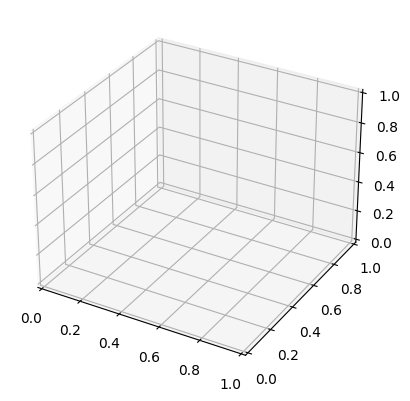

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Genera datos de ejemplo
# Supongamos que tienes una función z = f(x, y) = x^2 + y^2
def funcion_3d(x, y):
    return x**2 + y**2

# Genera valores para x, y
x = [vector[i][3] for i in range(len(vector))]
y = [vector[i][2] for i in range(len(vector))]

# Crea una malla de puntos (x, y)
x, y = np.meshgrid(x, y)

# Calcula los valores de la función z para cada par (x, y)
z = val2

# Crea la figura y el objeto de los ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grafica el mapa de calor 3D
sc = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
fig.colorbar(sc, label='Valor de Z')

# Añade etiquetas a los ejes
ax.set_xlabel('Eje X. g')
ax.set_ylabel('Eje Y. k')
ax.set_zlabel('Eje Z')
ax.set_title('Mapa de Calor en 3D')

# Muestra la gráfica
plt.show()



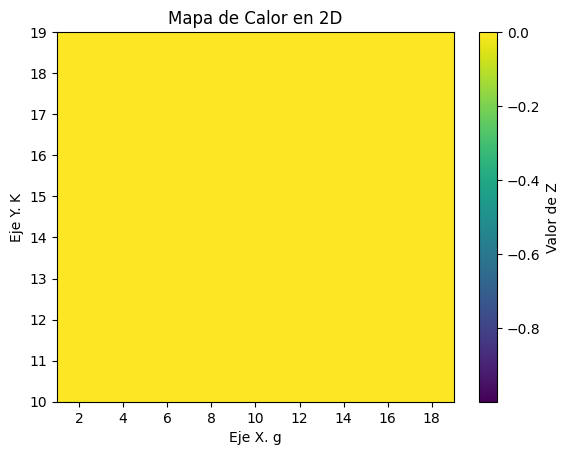

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Genera datos de ejemplo
# Supongamos que tienes una función z = f(x, y) = x^2 + y^2
def funcion_2d(x, y):
    return x**2 + y**2

# Genera valores para x, y
x = [vector[i][3] for i in range(len(vector))]
y = [vector[i][2] for i in range(len(vector))]

# Crea una malla de puntos (x, y)
x, y = np.meshgrid(x, y)

# Calcula los valores de la función z para cada par (x, y)
z = val2

# Crea un mapa de calor 2D
plt.imshow(z, extent=(min(x[0]), max(x[0]), min(y[:, 0]), max(y[:, 0])),
           cmap='viridis', origin='lower', aspect='auto')

# Añade etiquetas y título
plt.colorbar(label='Valor de Z')
plt.xlabel('Eje X. g')
plt.ylabel('Eje Y. K')
plt.title('Mapa de Calor en 2D')

# Muestra el mapa de calor
plt.show()


In [27]:
val2[20, 20], vector[20][2], vector[20][1]

(0.0, 1.1, 1.0)

In [ ]:
val2[1536, 38], vector[1536][1], vector[38][2]

(-0.7628701514768211, 8.1, 0.5)

In [19]:
contador = 0
for i in range(len(val2)):
  for j in range(len(val2)):
    if(val2[i, j] > 0.5):
      print(i, j)
      contador += 1

In [20]:
contador

0

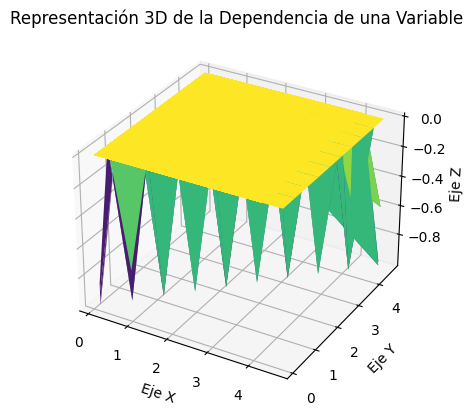

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Genera datos de ejemplo
# Supongamos que tienes una función z = f(x, y) = x^2 + y^2
def funcion_3d(x, y):
    return x**2 + y**2

# Genera valores para x, y
x = [vector[i][3] for i in range(len(vector))]
y = [vector[i][2] for i in range(len(vector))]

# Crea una malla de puntos (x, y)
x, y = np.meshgrid(x, y)

# Calcula los valores de la función z para cada par (x, y)
z = val2

# Crea la figura y el objeto de los ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grafica la superficie 3D
ax.plot_surface(x, y, z, cmap='viridis')

# Añade etiquetas a los ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
ax.set_title('Representación 3D de la Dependencia de una Variable')

# Muestra la gráfica
plt.show()


Vamos a ver a partir de qué valor de g se tienen muchas actuaciones del operador de salto

In [ ]:
sigma = 1.0
dt = 0.01
N = 5
w = 1.0*sigma
k = 1.0*sigma
g = 0.1*sigma
params = [sigma, w, k, g]
i = 0
d0 = densidad(N)
print('densidad hecha')
vector1, vector2, vectorg = [], [], []
while(i<20):
  print('Iteracion para ' + 'g = ' + str(g) + ': ' + str(i))
  H, J = dicke(N, params)
  #Heff = H_eff(H, [J])
  L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])
  U = Mpemba(L, d0, N)
  d0_exp = np.dot(np.dot(U, d0), np.conjugate(U.T))
  v1, tiempo, n1 = ResolverSistema(d0, H, [J], N)
  v2, tiempo, n2 = ResolverSistema(d0_exp, H, [J], N)
  vector1.append(n1)
  vector2.append(n2)
  vectorg.append(g)
  print('n1: ' + str(n1) + '\n')
  print('n2: ' + str(n2) + '\n')
  g += 0.1*sigma
  params = [sigma, w, k, g]
  i += 1

In [ ]:
vectorg

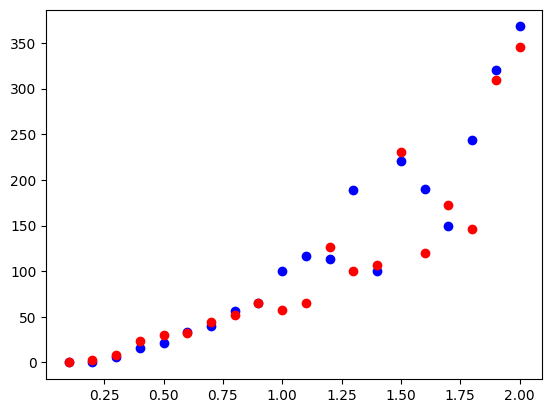

In [ ]:
vector1 = [0,
 1,
 6,
 16,
 21,
 33,
 40,
 56,
 65,
 100,
 117,
 113,
 189,
 100,
 221,
 190,
 149,
 244,
 320,
           368]
vector2 = [1,
 3,
 8,
 23,
 30,
 32,
 44,
 52,
 65,
 57,
 65,
 127,
 100,
 107,
 230,
 120,
 172,
 146,
 309,
 345]
vectorg = [0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 1.2,
 1.3,
 1.4000000000000001,
 1.5000000000000002,
 1.6000000000000003,
 1.7000000000000004,
 1.8000000000000005,
 1.9000000000000006,
 2.0000000000000004]
plt.plot(vectorg, vector1, 'bo')
plt.plot(vectorg, vector2, 'ro')